In [1]:
# User
user = "nk1922"

# Imports
import torch
from torch import nn
from torch.distributions import Normal,Laplace,Uniform
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Cocycle_code'.format(user))
from Cocycle_CDAGM import *
from Cocycle_model import *
from Cocycle_optimise import *
from Cocycle_preprocess import *
from Cocycle_loss_functions import *
from Conditioners import *
from Transformers import *
from Helper_functions import *
from KDE_estimation import *
from Kernels import *
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Flows_code'.format(user))
from RQS import *
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Experimental_results'.format(user))

tensor(4.8990)


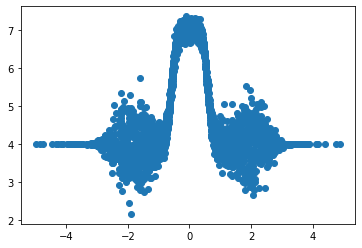

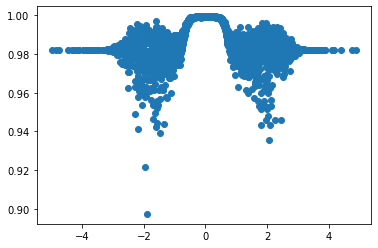

In [9]:
# DGP
N = 2500
D = 1
X = Normal(0,1).sample((N,D))*1.5
U = Normal(0,1).sample((N,1))
Y = 4+3*((1+10*X**6)**-2 + 0.2*torch.exp(-1/10*(X+2)**2*(X-2)**2)*U)
print(Y.mean())
plt.scatter(X.T,Y.T);
plt.show();
plt.scatter(X.T,torch.sigmoid(Y.T));

In [4]:
# Function estimation
cocycle_loss = "CMMD_M_RFF"
RFF_features,nfeat = True,100
batch_size = 128
maxiter = 10000
miniter = 10000
train_val_split = 0.8
med_heuristic = True
ntrain = int(train_val_split*N)

features = lambda Y : torch.row_stack((Y[None,:],Y[None,:]**2))

# Data Preprocessing
if train_val_split == 1:
    inputs_train,outputs_train, inputs_val,outputs_val = X,Y,[],[]
else:
    inputs_train,outputs_train, inputs_val,outputs_val = X[:ntrain],Y[:ntrain],X[ntrain:],Y[ntrain:]
    
if cocycle_loss in ["JMMD","CLS"]:
    inputs_train,outputs_train, = preprocess(independent_pairs = False,asymmetric_pairs = True)(inputs_train,outputs_train)
    if train_val_split != 1:
        inputs_val,outputs_val, = preprocess(independent_pairs = False,asymmetric_pairs = True)(inputs_val,outputs_val)
    else:
        inputs_val,outputs_val, = [],[]  

# Getting loss function
loss_fn = Loss(loss_fn = cocycle_loss,kernel = [gaussian_kernel(torch.ones(1),1),gaussian_kernel(torch.ones(1),1)], features = features)
if med_heuristic:
    loss_fn.median_heuristic(inputs_train,outputs_train, subsamples = 10**4)

# Getting RFF features
if RFF_features:
    loss_fn.get_RFF_features(nfeat)

# Defining and training model
conditioner_shift = NN_Conditioner(width = 128, layers = 2, input_dims =  D, output_dims = 1 ,bias = True)
conditioner_scale = NN_Conditioner(width = 128, layers = 2, input_dims =  D, output_dims = 1 ,bias = True)
#conditioner_scale = Lin_Conditioner(1,1)
transformer = Softplus_Affine_Transformer(log_det = cocycle_loss == "MLE")
model = cocycle_model([conditioner_shift,conditioner_scale],transformer)
model = train(model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size, val_batch_size = N,conditioner_learn_rate = 1e-3,
                              transformer_learn_rate = 1e-4,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = 1e-4, scheduler = True,n_schedule = 100)

Training loss last 10 avg is : tensor(0.0605)
Validation loss last 10 avg is : tensor(0.0719)
Completion % : 57.809999999999995


KeyboardInterrupt: 

In [ ]:
model = train(model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size, val_batch_size = N,conditioner_learn_rate = 1e-4,
                              transformer_learn_rate = 1e-4,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = 1e-4, scheduler = False,n_schedule = 100)

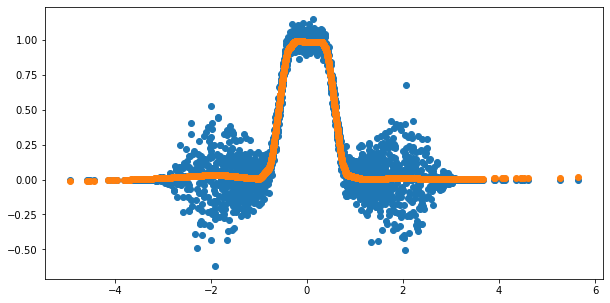

In [7]:
model.transformer.ld = False
Yhat = model.transformation(X,model.inverse_transformation(X,Y).mean()).detach()
fig,axs = plt.subplots(figsize = (10,5))
plt.scatter(X.T,Y.T)
plt.scatter(X.T,Yhat.T);

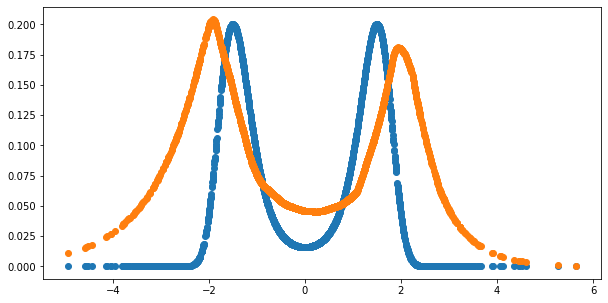

In [10]:
fig,axs = plt.subplots(figsize = (10,5))
#plt.show()
#plt.scatter(X, torch.abs(0.2*torch.sign(X)*torch.abs(X)**0.5))
#fig,axs = plt.subplots(figsize = (10,5))
plt.scatter(X,0.2*torch.exp(-1/2*(X+1.5)**2*(X-1.5)**2))
plt.scatter(X,torch.log(1+torch.exp(conditioner_scale.forward(X).detach())))
plt.show()

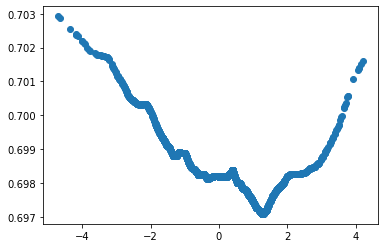

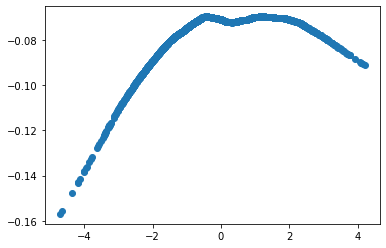

In [85]:
# Defining model
conditioner_shift = NN_Conditioner(width = 128, layers = 5, input_dims =  D, output_dims = 1 ,bias = True)
conditioner_scale = NN_Conditioner(width = 128, layers = 5, input_dims =  D, output_dims = 1 ,bias = True)
transformer = Softplus_Affine_Transformer(log_det = cocycle_loss == "MLE")
model = cocycle_model([conditioner_shift,conditioner_scale],transformer)

plt.scatter(X,torch.log(1+torch.exp(conditioner_scale.forward(X).detach())))
plt.show()
plt.scatter(X,conditioner_shift.forward(X).detach())
plt.show()